# Synthetic Clear Sky

In this notebook, we generate a synthetic power signal for a system located in souther California. We make use of the `pvlib-python` PV modeling package. The goal is to compare the solar eigenvectors generated by this method to the eigenvectors generated from real data.

In [1]:
from sys import path
path.append('..')
from clearsky.main import IterativeClearSky
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.location import Location
from pvlib.modelchain import ModelChain
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', palette='colorblind', context='talk')

Load the Sandia module and CEC inverter databases.

In [2]:
# load some module and inverter specifications
sandia_modules = retrieve_sam('SandiaMod')
cec_inverters = retrieve_sam('cecinverter')

sandia_module = sandia_modules['SunPower_SP305_GEN_C_Module__2008__E__']
cec_inverter = cec_inverters['SMA_America__SB3000US_240V__CEC_2007_']

Set up the system and location  model chain.

In [3]:
location = Location(latitude=33.68, longitude=-117.82, altitude=60, tz='America/Los_Angeles')
system = PVSystem(surface_tilt=30, surface_azimuth=100,
                  module_parameters=sandia_module,
                  inverter_parameters=cec_inverter)
mc = ModelChain(system, location)

Create the time index for the simulated data.

In [4]:
times = pd.DatetimeIndex(start='2016-01-01', end='2017-01-01', freq='5min', tz=location.tz)

In [5]:
try:
    mc.run_model(times=times)
except KeyError as e:
    print(e)

Below we inspect a single day in the simulated data set.

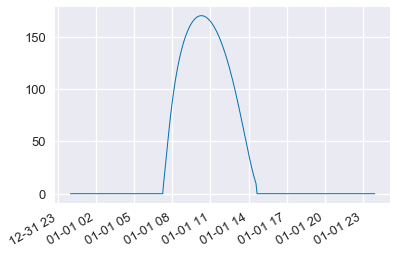

In [6]:
mc.ac.loc['2016-01-01':'2016-01-01'].plot(linewidth=1)

In [7]:
D = mc.ac.values[:-1].reshape(288, -1, order='F')
p = mc.ac.values

In [8]:
cloudy_days = np.sort(np.random.choice(np.arange(D.shape[1]), size=int(0.3 * D.shape[1]), replace=False))
C = np.ones_like(D)
for cd in cloudy_days:
    C[:, cd] = np.random.uniform(0, 1.1, C.shape[0])

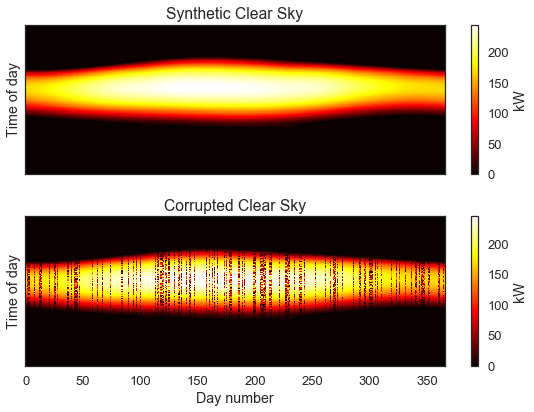

In [9]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=2, figsize=(8,6), sharex=True)
    foo = ax[0].imshow(D, cmap='hot', interpolation='none', aspect='auto')
    ax[0].set_title('Synthetic Clear Sky')
    bar = ax[1].imshow(np.multiply(D, C), cmap='hot', vmin=0, vmax=np.max(D), interpolation='none', aspect='auto')
    ax[1].set_title('Corrupted Clear Sky')
    plt.colorbar(foo, ax=ax[0], label='kW')#, ticks=range(0, 30, 5))
    plt.colorbar(bar, ax=ax[1], label='kW')#, ticks=range(0, 30, 5))
    ax[1].set_xlabel('Day number')
    ax[0].set_yticks([])
    ax[0].set_ylabel('Time of day')
    ax[1].set_yticks([])
    ax[1].set_ylabel('Time of day')
    plt.tight_layout()

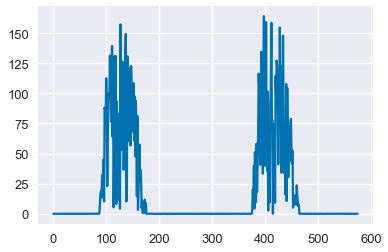

In [10]:
plt.plot(np.multiply(D, C)[:, 2:4].ravel(order='F'))

In [11]:
ics = IterativeClearSky(D * C, k=5)

In [12]:
ics.mu_L = 5e2
ics.mu_R = 1e3
ics.tau = 0.9
ics.minimize_objective(max_iter=20)

starting at 16728585.063 [46857.06148852545, 1828.9887774128542, 16679899.012654593, 0]
iteration 1: 22666.568 [19392.167    29.728  3244.672     0.   ]
iteration 2: 17266.269 [14230.902    62.96   2972.407     0.   ]
iteration 3: 14436.969 [11317.471    76.09   3043.408     0.   ]
iteration 4: 13078.282 [9912.395   86.462 3079.425    0.   ]
iteration 5: 12135.055 [8853.245   91.575 3190.236    0.   ]
iteration 6: 11510.378 [8164.979   96.134 3249.265    0.   ]
iteration 7: 11107.698 [7730.943  100.308 3276.447    0.   ]
iteration 8: 10697.713 [7327.869  103.686 3266.158    0.   ]
iteration 9: 10345.331 [7003.933  104.354 3237.044    0.   ]
iteration 10: 10069.900 [6754.986  105.264 3209.65     0.   ]
iteration 11: 9882.413 [6578.51   105.729 3198.175    0.   ]
iteration 12: 9726.890 [6446.969  106.926 3172.996    0.   ]
iteration 13: 9571.828 [6307.01   108.451 3156.368    0.   ]
iteration 14: 9413.812 [6159.936  109.256 3144.62     0.   ]
iteration 15: 9257.123 [6005.875  109.979 314

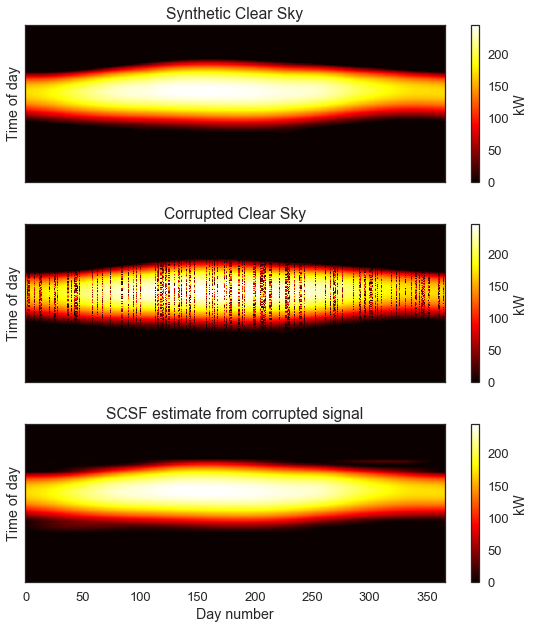

In [13]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=3, figsize=(8,9), sharex=True)
    foo = ax[0].imshow(D, cmap='hot', interpolation='none', aspect='auto')
    ax[0].set_title('Synthetic Clear Sky')
    bar = ax[2].imshow(ics.L_cs.value.dot(ics.R_cs.value), cmap='hot', vmin=0, vmax=np.max(D), interpolation='none', aspect='auto')
    ax[2].set_title('SCSF estimate from corrupted signal')
    fubar = ax[1].imshow(D*C, cmap='hot', interpolation='none', aspect='auto', vmin=0, vmax=np.max(D))
    ax[1].set_title('Corrupted Clear Sky')
    plt.colorbar(foo, ax=ax[0], label='kW')#, ticks=range(0, 30, 5))
    plt.colorbar(bar, ax=ax[2], label='kW')#, ticks=range(0, 30, 5))
    plt.colorbar(fubar, ax=ax[1], label='kW')
    ax[2].set_xlabel('Day number')
    ax[0].set_yticks([])
    ax[0].set_ylabel('Time of day')
    ax[1].set_yticks([])
    ax[1].set_ylabel('Time of day')
    ax[2].set_yticks([])
    ax[2].set_ylabel('Time of day')
    plt.tight_layout()

In [14]:
np.linalg.norm(D - ics.L_cs.value.dot(ics.R_cs.value), 'fro')

1126.4277526392832

In [15]:
np.linalg.norm(D, 'fro')

32910.42510071853

In [16]:
np.linalg.norm(D - ics.L_cs.value.dot(ics.R_cs.value), 'fro') / np.linalg.norm(D, 'fro')

0.03422707999644435

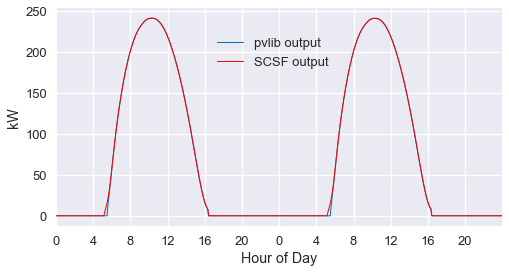

In [17]:
D1 = 205
D2 = D1 + 2
actual = p[D1*288:D2*288]
clearsky = ((ics.L_cs.value.dot(ics.R_cs.value)))[:, D1:D2].ravel(order='F')
fig, ax = plt.subplots(nrows=1, figsize=(8,4))
ax.plot(actual, linewidth=1, label='pvlib output')
ax.plot(clearsky, linewidth=1, color='red', label='SCSF output')
plt.legend(loc=(.35,.7))
ax.set_xlim(0, 288*(D2-D1))
ax.set_ylabel('kW')
ax.set_xticks(np.arange(0, 288*2, 2*24))
ax.set_xticklabels(np.tile(np.arange(0,24,4),2))
ax.set_xlabel('Hour of Day')
plt.show()

(0, 288)

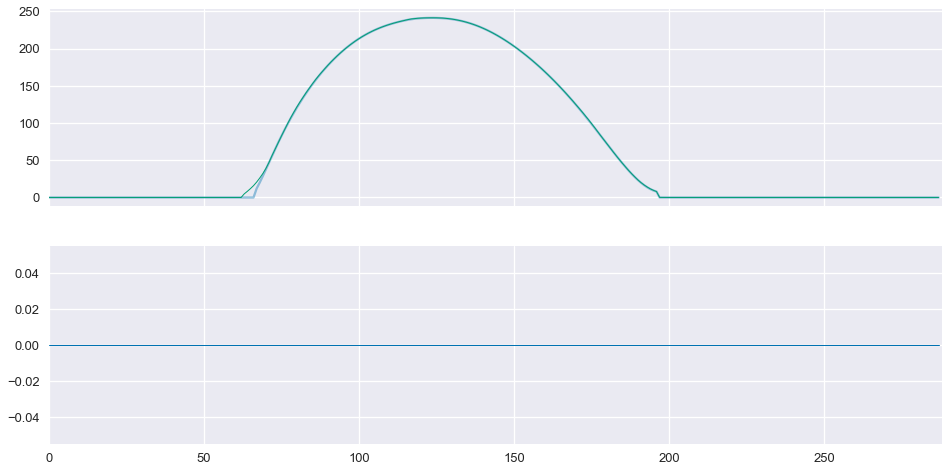

In [18]:
D1 = 205
D2 = D1+1
actual = p[D1*288:D2*288]
clearsky = ((ics.L_cs.value.dot(ics.R_cs.value)))[:, D1:D2].ravel(order='F')
fig, ax = plt.subplots(nrows=2, figsize=(16,8), sharex=True)
ax[0].plot(actual, alpha=0.4)
ax[0].plot(clearsky, linewidth=1)
ax[1].plot(np.repeat(ics.weights[D1:D2], 288), linewidth=1)
ax[1].set_xlim(0, 288*(D2-D1))